# Task2--- 特征工程

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 导入训练集和测试集，分成 特征X 和 目标Y

In [12]:
df_train=pd.read_csv('df_train.csv',index_col=0)
df_test=pd.read_csv('df_test.csv',index_col=0)

In [13]:
Xtrain=df_train.loc[:,df_train.columns!='status']
Ytrain=df_train.loc[:,'status']

Xtest=df_test.loc[:,df_test.columns!='status']
Ytest=df_test.loc[:,'status']

In [14]:
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(3327, 87)
(3327,)
(1427, 87)
(1427,)


In [15]:
Xtrain.head()

,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,...,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day,reg_preference_for_trad_一线城市,reg_preference_for_trad_三线城市,reg_preference_for_trad_二线城市,reg_preference_for_trad_其他城市,reg_preference_for_trad_境外
296,0.01,0.99,4000,0.96,1.00,0.405,16.0,29.0,28.0,1.0,...,7.0,15600.0,8228.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0
8545,0.03,0.97,500,0.87,1.00,0.205,18.0,27.0,27.0,3.0,...,5.0,21600.0,7160.0,30.0,27.0,1.0,0.0,0.0,0.0,0.0
7641,0.02,0.86,0,1.98,0.70,0.205,18.0,53.0,33.0,2.0,...,5.0,13800.0,10320.0,3.0,137.0,1.0,0.0,0.0,0.0,0.0
1193,0.02,0.81,1000,1.49,0.73,0.555,23.0,15.0,8.0,4.0,...,12.0,17400.0,6418.0,20.0,51.0,0.0,1.0,0.0,0.0,0.0
10,0.02,0.94,2000,1.28,1.00,0.458,19.0,30.0,14.0,4.0,...,6.0,22800.0,9360.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0


## 1.无量纲化----标准化StandardScaler

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
scaler=StandardScaler().fit(Xtrain)

In [18]:
Xtrain_scaler=scaler.transform(Xtrain)
Xtest_scaler=scaler.transform(Xtest)

In [19]:
Xtrain_scaler.shape

(3327, 87)

## 2.特征选择-随机森林法

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
RFC=RandomForestClassifier(n_estimators=1000).fit(Xtrain_scaler,Ytrain)

In [22]:
importance=RFC.feature_importances_   # 看一下每一个特征的重要性

In [23]:
importance_data = pd.DataFrame({'columns':Xtrain.columns,'importance':importance}).sort_values("importance",ascending=False)

In [24]:
importance_data.head(7)

,columns,importance
29,trans_fail_top_count_enum_last_1_month,0.053751
63,history_fail_fee,0.047815
51,loans_score,0.035880
41,apply_score,0.028364
55,loans_overdue_count,0.024565
65,latest_one_month_fail,0.021293
18,trans_amount_3_month,0.016907


In [25]:
score1=[]
for i in [0,0.001,0.005,0.01]:
    Xtrain_rfc=Xtrain_scaler[:,importance_data[importance_data['importance']>=i].index]
    Xtest_rfc=Xtest_scaler[:,importance_data[importance_data['importance']>=i].index]
    rfc1=RandomForestClassifier(n_estimators=1000).fit(Xtrain_rfc,Ytrain)
    score1.append(rfc1.score(Xtest_rfc,Ytest))
    
print(score1)

[0.779957953749124, 0.7834618079887876, 0.7869656622284513, 0.7869656622284513]


In [26]:
# 准确率貌似降低，下次用 roc曲线来确定，本次保持不变。

## 3.特征过滤----方差过滤+相关性过滤

#### 方差过滤

In [27]:
from sklearn.feature_selection import VarianceThreshold   

In [28]:
selector=VarianceThreshold().fit(Xtrain_scaler)   #删除方差为0的特征，因为之前预处理貌似已经删除了，估计这里没有

In [29]:
Xtrain_variance=selector.transform(Xtrain_scaler)
Xtest_variance=selector.transform(Xtest_scaler)

In [30]:
print(Xtrain_variance.shape)
print(Xtest_variance.shape)

(3327, 87)
(1427, 87)


#### 互信息法

In [31]:
from sklearn.feature_selection import mutual_info_classif as MIC

In [32]:
result = MIC(Xtrain_variance,Ytrain)

In [33]:
k = result.shape[0] - sum(result <= 0)
k

50

In [34]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest

In [35]:
X_fsmic = SelectKBest(MIC, k).fit_transform(Xtrain_variance, Ytrain)
cross_val_score(RFC(n_estimators=500,random_state=0),X_fsmic,Ytrain,cv=5).mean()

0.7971178448128353

In [36]:
# 看到模型的准确率上升，可以选择这 57 个特征

In [37]:
MIC1 = SelectKBest(MIC, k).fit(Xtrain_variance, Ytrain)

In [38]:
Xtrain_MIC1=MIC1.transform(Xtrain_variance)

In [39]:
Xtest_MIC1=MIC1.transform(Xtest_variance)

In [40]:
Xtrain_MIC1.shape

(3327, 50)

In [41]:
Xtest_MIC1.shape

(1427, 50)

In [42]:
Ytrain.shape

(3327,)

In [43]:
Ytest.shape

(1427,)

## 降维PCA 

In [44]:
from sklearn.decomposition import PCA

In [45]:
pca= PCA()

In [46]:
import matplotlib.pyplot as plt

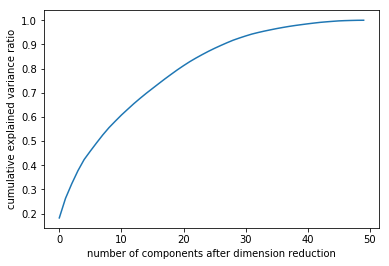

In [47]:
import numpy as np
pca_line = PCA().fit(Xtrain_MIC1)
plt.plot(np.cumsum(pca_line.explained_variance_ratio_))
plt.xlabel("number of components after dimension reduction")
plt.ylabel("cumulative explained variance ratio")
plt.show()

In [48]:
#  还是保持原来的57个特征

# Task3---建模 

In [50]:
Xtrain_MIC1.shape

(3327, 50)

In [51]:
Xtest_MIC1.shape

(1427, 50)

In [52]:
Ytrain.shape

(3327,)

In [53]:
Ytest.shape

(1427,)

In [59]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC

In [57]:
from xgboost import XGBClassifier as XGBC

In [58]:
from sklearn import metrics   #  模型的评分

In [60]:
lr=LR().fit(Xtrain_MIC1,Ytrain)
svc=SVC().fit(Xtrain_MIC1,Ytrain)
dtc=DTC().fit(Xtrain_MIC1,Ytrain)
rfc=RFC().fit(Xtrain_MIC1,Ytrain)
xgbc=XGBC().fit(Xtrain_MIC1,Ytrain)

D:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [61]:
lr.score(Xtest_MIC1,Ytest)

0.7834618079887876

In [62]:
svc.score(Xtest_MIC1,Ytest)

0.7785564120532585

In [63]:
dtc.score(Xtest_MIC1,Ytest)

0.677645409950946

In [64]:
rfc.score(Xtest_MIC1,Ytest)

0.7680448493342676

In [65]:
xgbc.score(Xtest_MIC1,Ytest)

0.7911702873160477